In [ ]:
########NODDI Bingham#########
# 1) Reads data and prepares model
# 2) Runs NODDI-Bigham implementation
# 3) Inline visualization of outputs

In [1]:
from dipy.core.gradients import gradient_table
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy
bvals0 = 'C://Users//310304075//Downloads//NODDI//sub-BMRI119477_dwi.bval'
bvecs0 = 'C://Users//310304075//Downloads//NODDI//sub-BMRI119477_dwi.bvec'
gt = gradient_table(bvals0, bvecs0)
acq_scheme_mipy = gtab_dipy2dmipy(gt)
acq_scheme_mipy.print_acquisition_info

Acquisition scheme summary

total number of measurements: 49
number of b0 measurements: 1
number of DWI shells: 2

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |N/A                      |N/A        |N/A       |N/A  
1           |16        |1000            |N/A                      |N/A        |N/A       |N/A  
2           |32        |2500            |N/A                      |N/A        |N/A       |N/A  


C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\acquisition_scheme.py:872: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.
  warn(msg)


In [3]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.distributions.distribute_models import SD2BinghamDistributed
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
bingham_dispersed_bundle = SD2BinghamDistributed(models=[stick, zeppelin])
bingham_dispersed_bundle.parameter_names
bingham_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
bingham_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
bingham_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)
NODDI_bingham_mod = MultiCompartmentModel(models=[ball, bingham_dispersed_bundle])
NODDI_bingham_mod.parameter_names
NODDI_bingham_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

(144, 144, 5, 49)


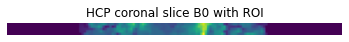

In [6]:
import nibabel as nib
import numpy as np
scheme_hcp = acq_scheme_mipy
data_hcp = nib.load('C://Users//310304075//Downloads//NODDI//eddy_corrected_dn_bfc_masked.nii//eddy_corrected_dn_bfc_masked.nii')
data_hcp=data_hcp.get_fdata()
data_hcp=data_hcp[:,:,30:35,:]
print(data_hcp.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 70, :, 30].T, origin='lower')
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [7]:
NODDI_fit_hcp = NODDI_bingham_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, solver='mix')
np.save('C://Users//310304075//Downloads//fitparamBinghamPreProcmix.npy', NODDI_fit_hcp)

Using parallel processing with 4 workers.
Setup MIX optimizer in 0.0 seconds



KeyboardInterrupt



SD2BinghamDistributed_1_SD2Bingham_1_mu
(144, 144, 5, 2)
SD2BinghamDistributed_1_SD2Bingham_1_psi
(144, 144, 5)
SD2BinghamDistributed_1_SD2Bingham_1_odi
(144, 144, 5)
SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction
(144, 144, 5)
SD2BinghamDistributed_1_partial_volume_0
(144, 144, 5)
partial_volume_0
(144, 144, 5)
partial_volume_1
(144, 144, 5)


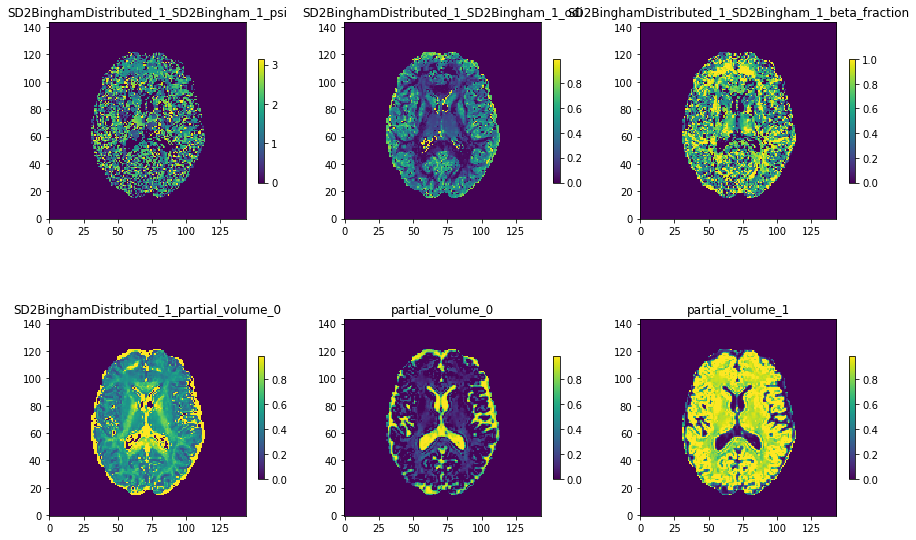

In [5]:
NODDI_fit_hcp = np.load('C://Users//310304075//Downloads//fitparamBinghamPreProcmix.npy',allow_pickle='TRUE').item()
fitted_parameters = NODDI_fit_hcp.fitted_parameters
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    print (name)
    print (values.shape)
    if counter != 0:
        cf = axs[counter-1].imshow(values[:,:,3].T, origin='lower', interpolation='nearest')
        axs[counter-1].set_title(name)
        fig.colorbar(cf, ax=axs[counter-1], shrink=0.5)
    counter += 1

C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:263: RuntimeWarning: divide by zero encountered in true_divide
  data_ = data / self.S0[..., None]
C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:263: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:250: RuntimeWarning: divide by zero encountered in true_divide
  data_ = data / self.S0[..., None]
C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:250: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


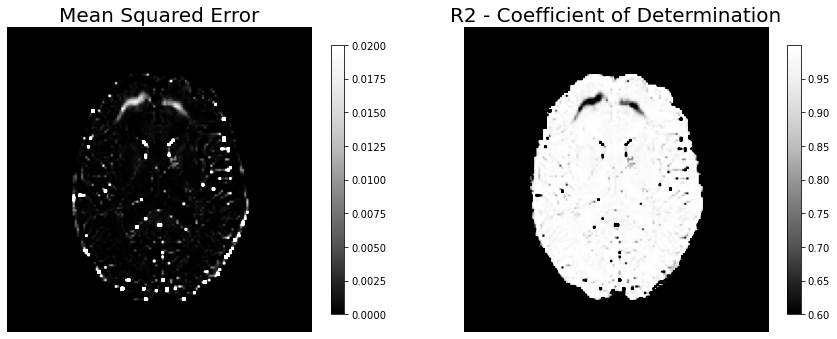

In [8]:
mse = NODDI_fit_hcp.mean_squared_error(data_hcp)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse[:,:,3].T, origin='lower', vmax=0.02, cmap='Greys_r')
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2[:,:,3].T, origin='lower', vmin=0.6, cmap='Greys_r')
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);